In [1]:
import pandas as pd
import numpy as np
import os

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

import warnings
warnings.filterwarnings('ignore')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version xgboost: {xgb.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")


Versión de las librerias utilizadas:
- Version xgboost: 1.7.6
- Version pandas: 2.2.3
- Version numpy: 1.26.4
- Version sklearn: 2.2.3


In [2]:
# Configuración
num_sample_per_class = 1000

In [3]:
# Cargar datasets
try:
    data = pd.read_csv('../Datasets/datasetMulti_original.csv')
    print("Dataset original cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

try:
    data_gen = pd.read_csv('../Datasets/datasetMulti_Gen.csv')
    print("Dataset generado cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Dataset original cargado correctamente.
Dataset generado cargado correctamente.


In [4]:

# Preprocesar dataset original
columns_to_drop = ['ID', 'No_Pation']
existing_columns = [col for col in columns_to_drop if col in data.columns]
if existing_columns:
    data = data.drop(columns=['ID', 'No_Pation'])

data['CLASS'] = data['CLASS'].astype(str).str.strip()
data['Gender'] = data['Gender'].astype(str).str.strip().str.upper()

class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data['CLASS'] = data['CLASS'].map(class_mapping)

data = pd.get_dummies(data, columns=['Gender'], drop_first=True)
data.dropna(inplace=True)
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento dataset original listo.")
data_sample = data

Preprocesamiento dataset original listo.


In [5]:
# Preprocesar dataset generado
columns_to_drop = ['ID', 'No_Pation']
existing_columns = [col for col in columns_to_drop if col in data_gen.columns]
if existing_columns:
    data_gen = data_gen.drop(columns=['ID', 'No_Pation'])

data_gen['CLASS'] = data_gen['CLASS'].astype(str).str.strip()
data_gen['Gender'] = data_gen['Gender'].astype(str).str.strip().str.upper()

class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data_gen['CLASS'] = data_gen['CLASS'].map(class_mapping)

data_gen = pd.get_dummies(data_gen, columns=['Gender'], drop_first=True)
data_gen.dropna(inplace=True)
data_gen.columns = data_gen.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento dataset generado listo.")
data_gen_sample = data_gen


Preprocesamiento dataset generado listo.


In [6]:
data.info()
data_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       1000 non-null   int64  
 1   Urea      1000 non-null   float64
 2   Cr        1000 non-null   int64  
 3   HbA1c     1000 non-null   float64
 4   Chol      1000 non-null   float64
 5   TG        1000 non-null   float64
 6   HDL       1000 non-null   float64
 7   LDL       1000 non-null   float64
 8   VLDL      1000 non-null   float64
 9   BMI       1000 non-null   float64
 10  CLASS     1000 non-null   int64  
 11  Gender_M  1000 non-null   bool   
dtypes: bool(1), float64(8), int64(3)
memory usage: 87.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGE       150000 non-null  int64  
 1   Urea      150000 non-null  float64
 2   Cr        15

In [7]:
# Completar datos faltantes (igual que en MLP)
data_count = data['CLASS'].value_counts()
if ((0 in data_count) and (data_count[0] < num_sample_per_class)):
    class_0 = data_gen[data_gen['CLASS'] == 0].sample(n=num_sample_per_class-data_count[0], random_state=42)
if ((1 in data_count) and (data_count[1] < num_sample_per_class)):
    class_1 = data_gen[data_gen['CLASS'] == 1].sample(n=num_sample_per_class-data_count[1], random_state=42)
if ((2 in data_count) and (data_count[2] < num_sample_per_class)):
    class_2 = data_gen[data_gen['CLASS'] == 2].sample(n=num_sample_per_class-data_count[2], random_state=42)


In [8]:
balanced_train_data_gen = pd.concat([class_0, class_1, class_2]).sample(frac=1, random_state=42).reset_index(drop=True)
print("--- Distribución de clases completadas ---")
print(balanced_train_data_gen['CLASS'].value_counts())
data_gen_sample = balanced_train_data_gen

--- Distribución de clases completadas ---
CLASS
1    947
0    897
2    156
Name: count, dtype: int64


In [9]:
# Separar características y objetivos (igual que MLP)
x = data_sample.drop(columns=["CLASS"]).to_numpy()
y = data_sample["CLASS"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

x_gen = data_gen_sample.drop(columns=["CLASS"]).to_numpy()
y_gen = data_gen_sample["CLASS"].to_numpy()

X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(x_gen, y_gen, test_size=0.20, random_state=42, stratify=y_gen)
X_gen_train, X_gen_val, y_gen_train, y_gen_val = train_test_split(X_gen_train, y_gen_train, test_size=0.15, random_state=42, stratify=y_gen_train)


In [10]:

# Combinar datos (igual que MLP)
X_train_orig_pd = pd.DataFrame(X_train)
y_train_orig_pd = pd.Series(y_train)
X_test_orig_pd = pd.DataFrame(X_test)
y_test_orig_pd = pd.Series(y_test)

X_gen_train_pd = pd.DataFrame(X_gen_train)
y_gen_train_pd = pd.Series(y_gen_train)
X_gen_test_pd = pd.DataFrame(X_gen_test)
y_gen_test_pd = pd.Series(y_gen_test)

X_train = (pd.concat([X_gen_train_pd, X_train_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_train = (pd.concat([y_gen_train_pd, y_train_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

X_test = (pd.concat([X_gen_test_pd, X_test_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_test = (pd.concat([y_gen_test_pd, y_test_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

print(f"Datos finales - Train: {len(X_train)}, Test: {len(X_test)}")


Datos finales - Train: 2040, Test: 600


In [11]:
clf = xgb.XGBClassifier()

In [12]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],    
    'learning_rate': [0.001, 0.01],  
    'subsample': [0.8],     
    'colsample_bytree': [0.8]
}

In [13]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [20]:
directorio = os.getcwd()
carpeta = "../Guardar_modelo/ML"
archivo_xgb = f'Multi_ML_{num_sample_per_class}.xgb'

ruta = os.path.join(directorio, carpeta, archivo_xgb)

directorio_final_para_guardar = os.path.dirname(ruta)
os.makedirs(directorio_final_para_guardar, exist_ok=True)

best_model.save_model(ruta)

In [21]:
y_pred = grid_search.predict(X_test)

Model Accuracy: 0.9966666666666667
              precision    recall  f1-score   support

           N       1.00      1.00      1.00       200
           P       1.00      0.99      1.00       200
           Y       0.99      0.99      0.99       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



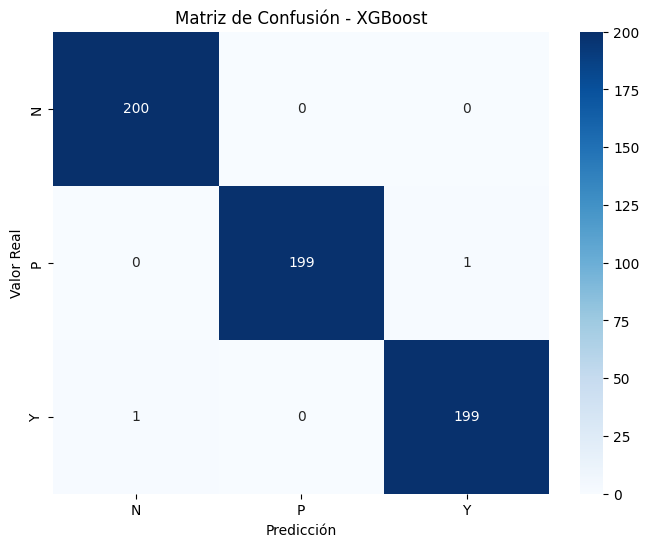

In [22]:
print('Model Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['N', 'P', 'Y']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
class_names = ['N', 'P', 'Y']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()